## Introduccion

El objetivo de este algoritmo es crear un proceso de contaminación de datos que permita la generación
de datos contaminados artificiales para su posterior consideración en el análisis de EEG limpios.
Para ello, se aplicará una técnica de contaminación que consiste en una combinacion lineal entre los datos EEG limpios y los datos EOG con un valor lambda que determina el alcance de esta contaminacion.

La generación de datos contaminados artificiales es importante ya que permite simular diferentes escenarios de contaminación y validar la efectividad de los métodos de limpieza y análisis de datos de EEG. Además, estos datos seran utilizados para entrenar y evaluar redes neuronales para la deteccion y eliminacion de artefactos EOG en señales EEG.

In [72]:
import numpy as np
import matplotlib.pyplot as plt

El primer paso es cargar los datos de EEG limpios y EOG, las señales se consideran limpias. Es importante considerar un analisis exploratorio de las bases de datos para entender el como se van a relacionar la una con la otra

Forma de la matriz EEG: (4514, 512)
Forma de la matriz EOG: (3400, 512)


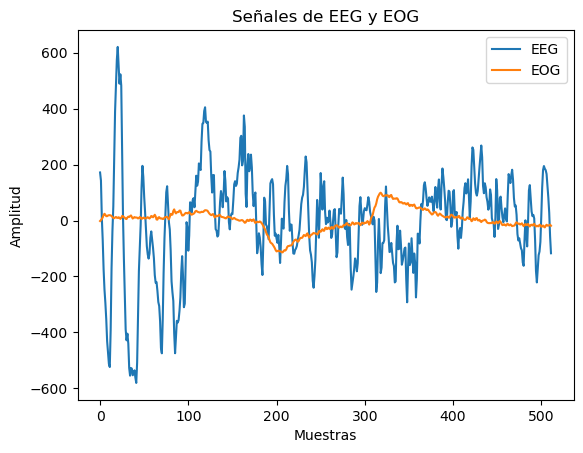

In [73]:
EEG_clean=np.load('data/EEG_all_epochs.npy')
EOG=np.load('data/EOG_all_epochs.npy')

x=EEG_clean.copy()
n=EOG.copy()

print('Forma de la matriz EEG:', x.shape)
print('Forma de la matriz EOG:', n.shape)
indice_senal = 1

plt.plot(x[indice_senal], label='EEG')
plt.plot(n[indice_senal], label='EOG')
plt.title('Señales de EEG y EOG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

Ahora para el proceso de contaminacion de los datos es importante calcular el RMS tanto de las señales EEG y EOG, con esta informacion podremos definir el ratio que se necesite entre la señal EEG y el ruido EOG.

Este SNR (Signal to Noise Ratio) se vera representado en un valor lambda.

In [74]:
SNR_values = np.arange(-7, 3)

# calculo de rms de la señal limpia
rms_sample_x = np.sqrt(np.mean(x**2, axis=1))
rms_general_x = np.mean(rms_sample_x)

# calculo de rms del ruido
rms_sample_n = np.sqrt(np.mean(n**2, axis=1))
rms_general_n = np.mean(rms_sample_n)

for SNR in SNR_values:
    lambd = np.sqrt(rms_general_x / rms_general_n) / (10 ** (SNR / 20))
    y = np.empty_like(x)
    for i in range(x.shape[0]):
        y[i, :] = x[i, :] + lambd * n[i % n.shape[0], :]
    
    np.save(f"data/EEG_contaminated_with_EOG/EEG_contaminated_with_EOG_{SNR}db.npy", y)



Definido un SNR vamos a estar aplicando la ecuacion $y=x+\lambda \cdot n$ para cada valor en la base de datos. Dado que hay menos muestras de EOG que de EEG, las señales de EOG se van a repetir a medida que se procesan las muestras de EEG. Esto se logra utilizando un ciclo for para recorrer todas las filas de la matriz EEG. Para cada fila de la matriz EEG, se selecciona una fila correspondiente de la matriz EOG para generar la señal contaminante $n$

De paso, se dejara definidio un indice de correlacion entre los datos como una forma de validacion de la contaminacion

In [75]:
corr = np.zeros(x.shape[0])

for i in range(x.shape[0]):
    corr[i] = np.corrcoef(x[i], y[i])[0, 1]

print('Coeficiente de correlación medio:', np.mean(corr))

Coeficiente de correlación medio: 0.8251333820688711


En el siguiente grafico se puede observar como la contaminacion afecto exitosamente la señal EEG y esta puede ser usada como forma de datos contaminados artificialmente

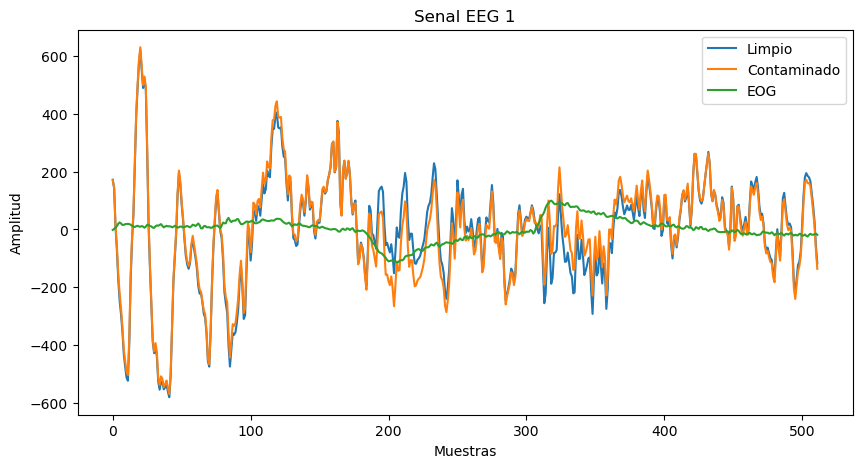

In [76]:
senal_x = x[indice_senal]
senal_y = y[indice_senal]

# Graficar la señal EEG limpia y contaminada
plt.figure(figsize=(10,5))
plt.plot(senal_x, label='Limpio')
plt.plot(senal_y, label='Contaminado')
plt.plot(n[indice_senal], label='EOG')
plt.legend()
plt.title(f'Senal EEG {indice_senal}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()